In [1]:
import os
import sys
import cv2
import sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Dense, Conv2D, Flatten, Activation,
                                     Dropout, MaxPooling2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from IPython.display import clear_output

In [2]:
!unzip '/content/drive/MyDrive/Colab Notebooks/Dataset/docs-data.zip'
clear_output()

In [3]:
print(f'Python version {sys.version}')
print(f'Scikit-learn version {sklearn.__version__}')
print(f'Tensorflow version {tf.__version__}')

Python version 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
Scikit-learn version 1.2.2
Tensorflow version 2.12.0


In [4]:
dataset_path_img = '/content/training/images'
dataset_path_metadata = '/content/training/metadata.csv'

random_state = 42

In [5]:
df = pd.read_csv(dataset_path_metadata)
df = df.sample(frac=1, ignore_index=True, random_state=random_state)
df.head()

,image,label
0,50_PG.png,Cap. PG 50mg
1,61_Povital.png,Tab. Povital
2,40_Relaxo.png,Tab. Relaxo 25mg
3,32_V-Plex.png,Tab. V-Plex
4,60_Relaxo.png,Tab. Relaxo 25mg


In [6]:
df.shape

(1354, 2)

In [7]:
def count_samples(df: pd.DataFrame, title: str='', is_save: bool=False) -> None:
    plt.figure(figsize=(15, 8))
    sns.countplot(x=df['label'], palette=['#432371',"#FAAE7B"])
    if title != '':
        plt.title(title)
    plt.xlabel('Medicine classes')
    plt.ylabel('Number of samples')
    plt.xticks(rotation=20, ha='right')
    if is_save:
        plt.savefig('./number-of-samples.png', dpi=300)
    plt.show()

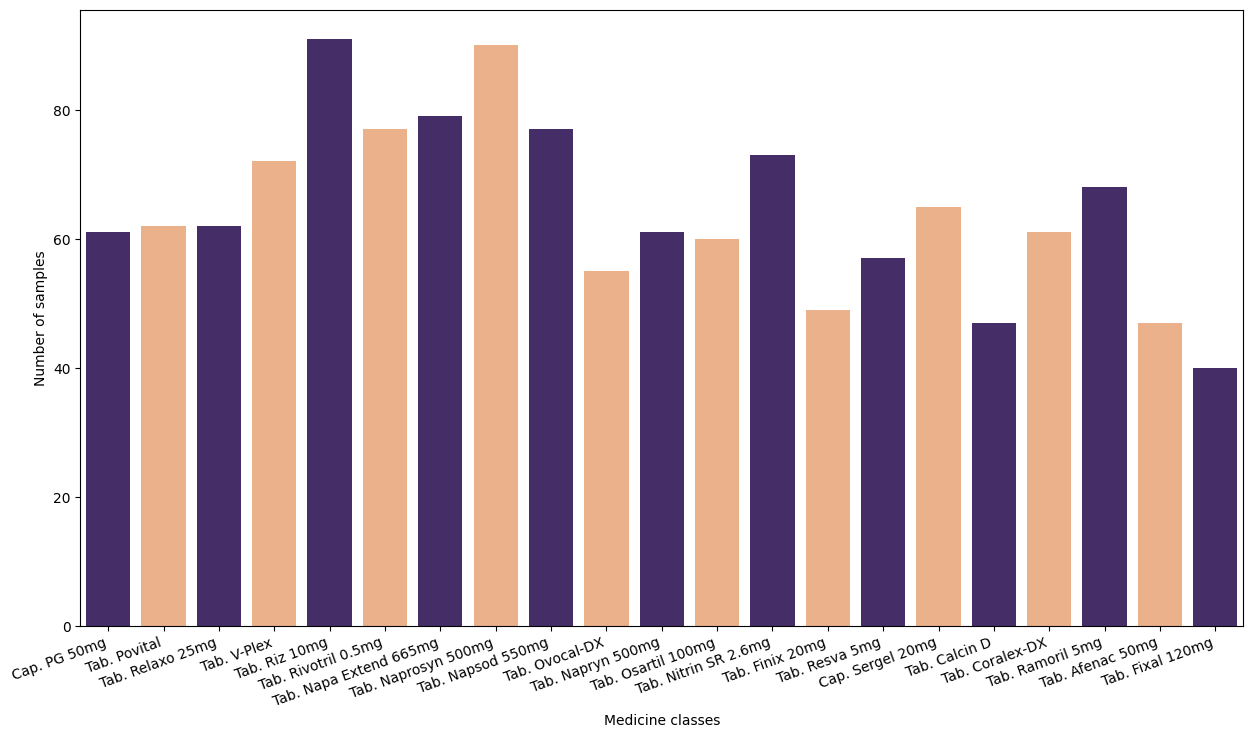

In [8]:
count_samples(df, '', True)

In [9]:
train_dataframe = df.sample(frac=0.8, random_state=random_state)
train_indices = train_dataframe.index

excluding_indices = df.index.isin(train_indices)
test_dataframe = df[~excluding_indices]

print('--Train--')
print(train_dataframe.head())
print(train_dataframe.shape)
print('--Test--')
print(test_dataframe.head())
print(test_dataframe.shape)

--Train--
                image                label
49      16_Napsod.png    Tab. Napsod 550mg
925         2_Riz.png        Tab. Riz 10mg
1034     33_Finix.png      Tab. Finix 20mg
1313  41_Rivotril.png  Tab. Rivotril 0.5mg
1054   56_Povital.png         Tab. Povital
(1083, 2)
--Test--
             image                   label
1   61_Povital.png            Tab. Povital
8    41_Extend.png  Tab. Napa Extend 665mg
13   50_Napryn.png       Tab. Napryn 500mg
14  33_Osartil.png      Tab. Osartil 100mg
16   29_Relaxo.png        Tab. Relaxo 25mg
(271, 2)


In [10]:
IMG_W = 256
IMG_H = 72
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 50
NO_CLASSES = 21
N_FOLD_SIZE = 5

input_shape = (IMG_H, IMG_W, CHANNELS)

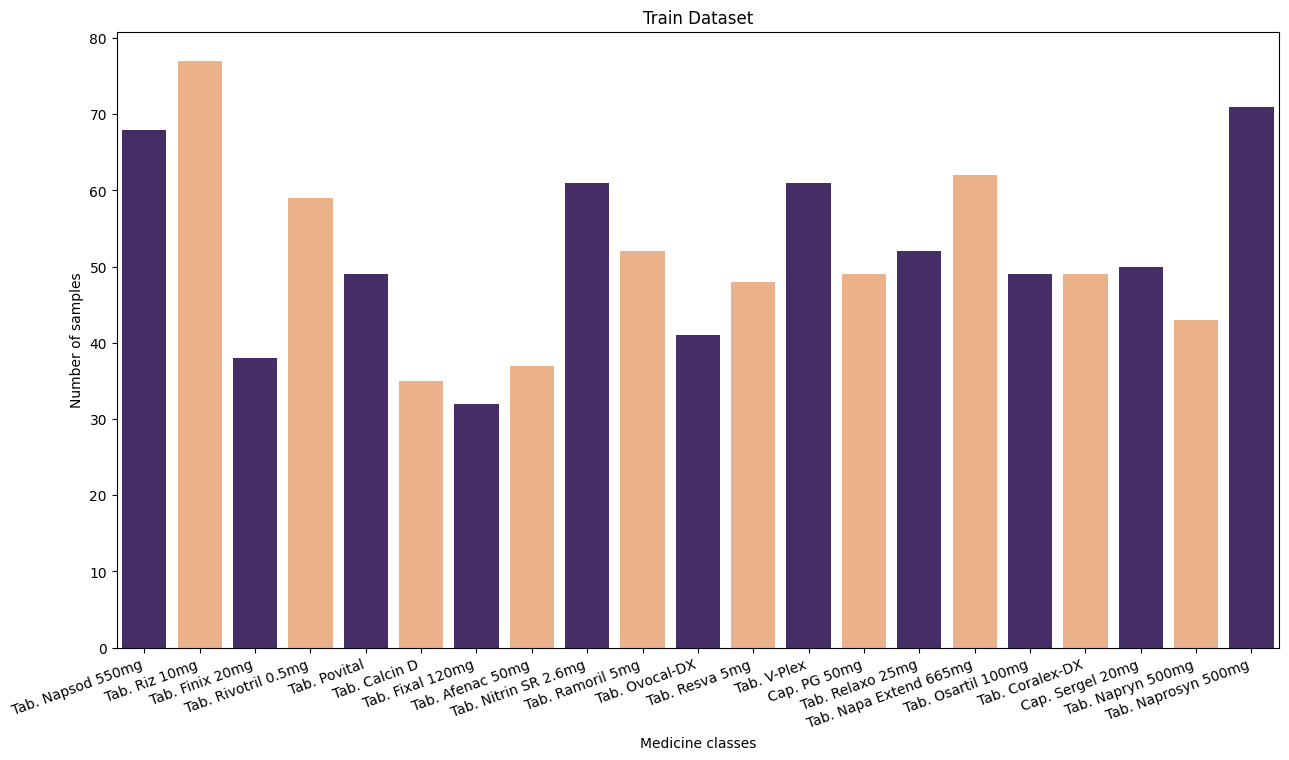

In [11]:
count_samples(train_dataframe, 'Train Dataset')

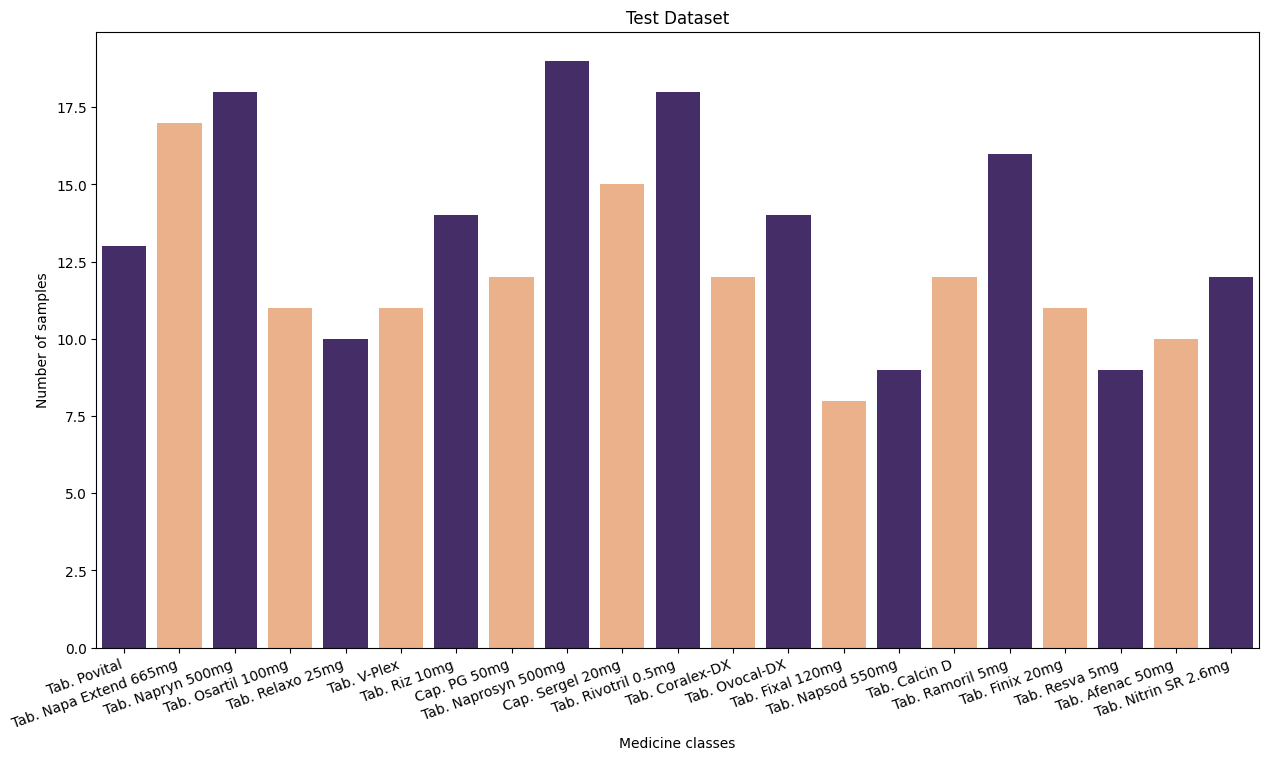

In [12]:
count_samples(test_dataframe, 'Test Dataset')

In [13]:
def plot_accuracy(history, model_name=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(25, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(50), acc, label='Training Accuracy')
    plt.plot(range(50), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(
        f'Training and Validation Accuracy {f"for {model_name}" if model_name else ""}')

    plt.subplot(1, 2, 2)
    plt.plot(range(50), loss, label='Training Loss')
    plt.plot(range(50), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(
        f'Training and Validation Loss {f"for {model_name}" if model_name else ""}')
    plt.savefig('./figures/model_accuracy.png')
    plt.show()

In [14]:
def create_model(no_classes):
    model = Sequential([
        # Conv 1
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        # Conv 2
        Conv2D(64,  kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        # Conv 3
        Conv2D(96,  kernel_size=(4, 4), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        # Conv 4
        Conv2D(96, (4, 4), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        # Conv 5
        Conv2D(128, (4, 4), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        # Conv 6
        Conv2D(128, (4, 4), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(no_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model

## Dataset Generation and Model Training

In [15]:
datagen = ImageDataGenerator(rescale=1./255)

In [16]:
test_set = datagen.flow_from_dataframe(dataframe=test_dataframe,
            directory=dataset_path_img,
            x_col='image', y_col='label',
            class_mode='categorical',
            target_size=(IMG_H, IMG_W),
            batch_size=BATCH_SIZE)

Found 271 validated image filenames belonging to 21 classes.


In [17]:
X = train_dataframe.drop('label', axis=1)
Y = train_dataframe[['label']]

In [18]:
kfold = StratifiedKFold(n_splits=N_FOLD_SIZE, shuffle=True, random_state=random_state)

In [19]:
fold_no = 1
acc_per_fold = []

In [20]:
for train_idx, val_idx in kfold.split(X, Y):
    train_df = train_dataframe.iloc[train_idx]
    valid_df = train_dataframe.iloc[val_idx]
    print(f'Fold No. {fold_no}')

    training_set = datagen.flow_from_dataframe(dataframe=train_df, directory=dataset_path_img,
                        x_col='image', y_col='label',
                        target_size=(IMG_H, IMG_W), batch_size=BATCH_SIZE)

    validation_set = datagen.flow_from_dataframe(dataframe=valid_df, directory=dataset_path_img,
                        x_col='image', y_col='label',
                        target_size=(IMG_H, IMG_W), batch_size=BATCH_SIZE)

    model = create_model(NO_CLASSES)
    history = model.fit(training_set, validation_data=validation_set,
                        epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    df = pd.DataFrame(data={ 'training_acc': train_acc, 'val_acc': val_acc, 'training_loss': train_loss, 'val_loss': val_loss })
    df.to_csv(f'CNN_Model_F_{fold_no}.csv')

    model.save('model_fold_' + str(fold_no)+'.h5')

    scores = model.evaluate(test_set, verbose=0)
    test_acc = scores[1] * 100
    acc_per_fold.append(test_acc)

    print(f'Test Accuracy {test_acc}')
    print('-----'*10)

    fold_no += 1

Fold No. 1
Found 866 validated image filenames belonging to 21 classes.
Found 217 validated image filenames belonging to 21 classes.
Epoch 1/50
28/28 [==============================] - 15s 94ms/step - loss: 3.0432 - accuracy: 0.0531 - val_loss: 3.0406 - val_accuracy: 0.0645
Epoch 2/50
28/28 [==============================] - 2s 54ms/step - loss: 3.0394 - accuracy: 0.0624 - val_loss: 3.0372 - val_accuracy: 0.0691
Epoch 3/50
28/28 [==============================] - 2s 63ms/step - loss: 3.0370 - accuracy: 0.0716 - val_loss: 3.0353 - val_accuracy: 0.0691
Epoch 4/50
28/28 [==============================] - 2s 77ms/step - loss: 3.0337 - accuracy: 0.0716 - val_loss: 3.0284 - val_accuracy: 0.0691
Epoch 5/50
28/28 [==============================] - 2s 59ms/step - loss: 3.0296 - accuracy: 0.0716 - val_loss: 3.0284 - val_accuracy: 0.0691
Epoch 6/50
28/28 [==============================] - 1s 52ms/step - loss: 3.0262 - accuracy: 0.0716 - val_loss: 3.0229 - val_accuracy: 0.0691
Epoch 7/50
28/28 [==

In [21]:
for idx, acc in enumerate(acc_per_fold):
    print(f'Accuracy for fold no. {idx+1} is: {acc}')

Accuracy for fold no. 1 is: 90.03689885139465
Accuracy for fold no. 2 is: 83.0258309841156
Accuracy for fold no. 3 is: 87.82287836074829
Accuracy for fold no. 4 is: 89.2988920211792
Accuracy for fold no. 5 is: 77.85977721214294


In [22]:
acc_arr = np.array(acc_per_fold)

In [23]:
acc_mean = acc_arr.mean()
acc_mean

85.60885548591614

In [24]:
acc_std = acc_arr.std()
acc_std

4.579215317898476

In [25]:
print(f'Accuracy in between {acc_mean-acc_std} to {acc_mean+acc_std}')

Accuracy in between 81.02964016801766 to 90.18807080381461
